<a href="https://colab.research.google.com/github/Ruma13/skin_cancer-tl/blob/main/Efficienttnet_B0%26B3_TL_Fusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SiLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              SiLU-6         [-1, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 112, 112]               0
           Conv2d-13         [-1, 16, 112, 112]             512
      BatchNorm2d-14         [-1, 16, 1

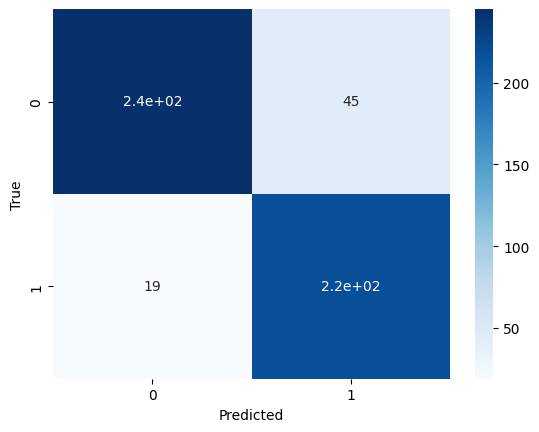

In [ ]:

import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, WeightedRandomSampler
from torchvision import datasets, transforms, models
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, mean_absolute_error, roc_auc_score
import seaborn as sns
from math import sqrt

# Dataset paths
train_dir = "/content/drive/MyDrive/Colab Dataset/train"
test_dir  = "/content/drive/MyDrive/Colab Dataset/test"

# Data transforms
train_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
test_dataset  = datasets.ImageFolder(test_dir, transform=test_transforms)

val_size = int(0.2 * len(test_dataset))
test_size = len(test_dataset) - val_size
val_dataset, final_test_dataset = random_split(test_dataset, [val_size, test_size])

class_counts = np.bincount([label for _, label in train_dataset.imgs])
class_weights = 1. / class_counts
sample_weights = [class_weights[label] for _, label in train_dataset.imgs]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(final_test_dataset, batch_size=32, shuffle=False)

# CBAM Attention
class CBAMBlock(nn.Module):
    def __init__(self, channels, reduction=16, kernel_size=7):
        super(CBAMBlock, self).__init__()
        self.channel_mlp = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(),
            nn.Linear(channels // reduction, channels, bias=False)
        )
        self.spatial_conv = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)

    def forward(self, x):
        b, c, h, w = x.size()
        avg_pool = F.adaptive_avg_pool2d(x, 1).view(b, c)
        max_pool = F.adaptive_max_pool2d(x, 1).view(b, c)
        channel_att = torch.sigmoid(self.channel_mlp(avg_pool) + self.channel_mlp(max_pool)).view(b, c, 1, 1)
        x = x * channel_att
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        spatial_att = torch.sigmoid(self.spatial_conv(torch.cat([avg_out, max_out], dim=1)))
        return x * spatial_att

# Fusion Model with EfficientNetB0
class FusionNet(nn.Module):
    def __init__(self, num_classes):
        super(FusionNet, self).__init__()
        self.backbone = models.efficientnet_b0(pretrained=True)
        self.backbone.classifier = nn.Identity()
        out_channels = 1280

        self.cbam = CBAMBlock(out_channels)

        self.mid_cnn = nn.Sequential(
            nn.Conv2d(out_channels, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1))
        )

        self.fc = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        features = self.backbone(x)

        # sometimes backbones return (B, C), expand to (B, C, 1, 1)
        if len(features.size()) == 2:
            features = features.view(features.size(0), -1, 1, 1)

        attn_features = self.cbam(features)
        mid_features = self.mid_cnn(attn_features)
        flat = torch.flatten(mid_features, 1)
        return self.fc(flat)


# Training setup
num_classes = len(train_dataset.classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FusionNet(num_classes).to(device)

summary(model, (3, 224, 224))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
writer = SummaryWriter("runs/efficientnetB0_experiment")
EPOCHS = 5

# Train function
def train_model(model, train_loader, val_loader, criterion, optimizer, device, writer):
    for epoch in range(EPOCHS):
        model.train()
        correct, total = 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
        print(f"Epoch {epoch+1}/{EPOCHS} Train Acc: {correct/total:.4f}")

train_model(model, train_loader, val_loader, criterion, optimizer, device, writer)

# Evaluation
model.eval()
all_preds, all_labels, all_probs = [], [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = F.softmax(outputs, dim=1)[:,1].cpu().numpy() if num_classes==2 else None
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        if probs is not None:
            all_probs.extend(probs)

acc = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds, average="weighted")
rec = recall_score(all_labels, all_preds, average="weighted")
f1 = f1_score(all_labels, all_preds, average="weighted")
mae = mean_absolute_error(all_labels, all_preds)
rmse = sqrt(np.mean((np.array(all_labels)-np.array(all_preds))**2))
auc = roc_auc_score(all_labels, all_probs) if num_classes==2 else None
cm = confusion_matrix(all_labels, all_preds)

print(f"Model: T_EfficientNetB0")
print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}")
print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}, AUC: {auc:.4f}" if auc else "AUC not computed")

sns.heatmap(cm, annot=True, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


EfficientNetB3


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B3_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth


100%|██████████| 47.2M/47.2M [00:00<00:00, 98.9MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 40, 112, 112]           1,080
       BatchNorm2d-2         [-1, 40, 112, 112]              80
              SiLU-3         [-1, 40, 112, 112]               0
            Conv2d-4         [-1, 40, 112, 112]             360
       BatchNorm2d-5         [-1, 40, 112, 112]              80
              SiLU-6         [-1, 40, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 40, 1, 1]               0
            Conv2d-8             [-1, 10, 1, 1]             410
              SiLU-9             [-1, 10, 1, 1]               0
           Conv2d-10             [-1, 40, 1, 1]             440
          Sigmoid-11             [-1, 40, 1, 1]               0
SqueezeExcitation-12         [-1, 40, 112, 112]               0
           Conv2d-13         [-1, 24, 112, 112]             960
      BatchNorm2d-14         [-1, 24, 1

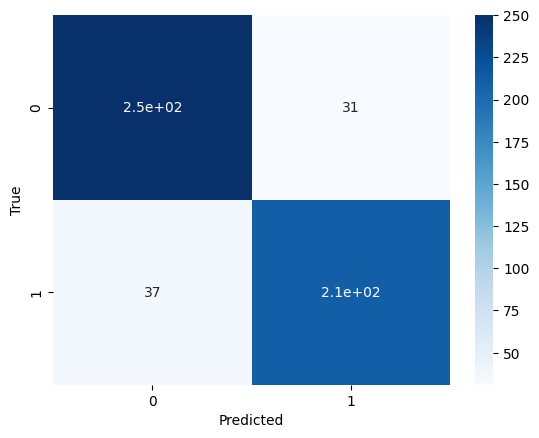

In [ ]:

import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, WeightedRandomSampler
from torchvision import datasets, transforms, models
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, mean_absolute_error, roc_auc_score
import seaborn as sns
from math import sqrt

# Dataset paths
train_dir = "/content/drive/MyDrive/Colab Dataset/train"
test_dir  = "/content/drive/MyDrive/Colab Dataset/test"

# Data transforms
train_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
test_dataset  = datasets.ImageFolder(test_dir, transform=test_transforms)

val_size = int(0.2 * len(test_dataset))
test_size = len(test_dataset) - val_size
val_dataset, final_test_dataset = random_split(test_dataset, [val_size, test_size])

class_counts = np.bincount([label for _, label in train_dataset.imgs])
class_weights = 1. / class_counts
sample_weights = [class_weights[label] for _, label in train_dataset.imgs]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(final_test_dataset, batch_size=32, shuffle=False)

# CBAM Attention
class CBAMBlock(nn.Module):
    def __init__(self, channels, reduction=16, kernel_size=7):
        super(CBAMBlock, self).__init__()
        self.channel_mlp = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(),
            nn.Linear(channels // reduction, channels, bias=False)
        )
        self.spatial_conv = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)

    def forward(self, x):
        b, c, h, w = x.size()
        avg_pool = F.adaptive_avg_pool2d(x, 1).view(b, c)
        max_pool = F.adaptive_max_pool2d(x, 1).view(b, c)
        channel_att = torch.sigmoid(self.channel_mlp(avg_pool) + self.channel_mlp(max_pool)).view(b, c, 1, 1)
        x = x * channel_att
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        spatial_att = torch.sigmoid(self.spatial_conv(torch.cat([avg_out, max_out], dim=1)))
        return x * spatial_att

# Fusion Model with EfficientNetB3
class FusionNet(nn.Module):
    def __init__(self, num_classes):
        super(FusionNet, self).__init__()
        self.backbone = models.efficientnet_b3(pretrained=True)
        self.backbone.classifier = nn.Identity()
        out_channels = 1536 # B0 was 1280


        self.cbam = CBAMBlock(out_channels)

        self.mid_cnn = nn.Sequential(
            nn.Conv2d(out_channels, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1))
        )

        self.fc = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        features = self.backbone(x)

        # sometimes backbones return (B, C), expand to (B, C, 1, 1)
        if len(features.size()) == 2:
            features = features.view(features.size(0), -1, 1, 1)

        attn_features = self.cbam(features)
        mid_features = self.mid_cnn(attn_features)
        flat = torch.flatten(mid_features, 1)
        return self.fc(flat)


# Training setup
num_classes = len(train_dataset.classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FusionNet(num_classes).to(device)

summary(model, (3, 224, 224))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
writer = SummaryWriter("runs/efficientnetB0_experiment")
EPOCHS = 5

# Train function
def train_model(model, train_loader, val_loader, criterion, optimizer, device, writer):
    for epoch in range(EPOCHS):
        model.train()
        correct, total = 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
        print(f"Epoch {epoch+1}/{EPOCHS} Train Acc: {correct/total:.4f}")

train_model(model, train_loader, val_loader, criterion, optimizer, device, writer)

# Evaluation
model.eval()
all_preds, all_labels, all_probs = [], [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = F.softmax(outputs, dim=1)[:,1].cpu().numpy() if num_classes==2 else None
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        if probs is not None:
            all_probs.extend(probs)

acc = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds, average="weighted")
rec = recall_score(all_labels, all_preds, average="weighted")
f1 = f1_score(all_labels, all_preds, average="weighted")
mae = mean_absolute_error(all_labels, all_preds)
rmse = sqrt(np.mean((np.array(all_labels)-np.array(all_preds))**2))
auc = roc_auc_score(all_labels, all_probs) if num_classes==2 else None
cm = confusion_matrix(all_labels, all_preds)

print(f"Model: T_EfficientNetB0")
print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}")
print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}, AUC: {auc:.4f}" if auc else "AUC not computed")

sns.heatmap(cm, annot=True, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
